In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os.path
from sklearn.model_selection import train_test_split
import tensorflow as tf
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, f1_score

In [2]:
def imgPaths(filepath):
    labels = [Path(path).parent.name for path in filepath]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    
    df = pd.concat([filepath, labels], axis=1)
    df = df.sample(frac=1).reset_index(drop=True)
    
    return df

In [3]:
train_image_dir = Path('content/asl_alphabet_train/asl_alphabet_train')
train_filepaths = list(train_image_dir.glob(r'**/*.jpg'))
test_image_dir = Path('content/asl_alphabet_test/asl_alphabet_test')
test_filepaths = list(train_image_dir.glob(r'**/*.jpg'))

files = list(train_image_dir.glob(r'**/*.jpg'))
label = []
for i in range(len(files)):
    label.append(files[0].stem[0])

df = pd.DataFrame({
    'File Path': [file for file in files if file.is_file()],
    'File Name': [file.name for file in files if file.is_file()],
    'File Size': [file.stat().st_size for file in files if file.is_file()]
})

print(df)

                                               File Path  File Name  File Size
0      content\asl_alphabet_train\asl_alphabet_train\...     A1.jpg      11650
1      content\asl_alphabet_train\asl_alphabet_train\...    A10.jpg      11584
2      content\asl_alphabet_train\asl_alphabet_train\...   A100.jpg      11731
3      content\asl_alphabet_train\asl_alphabet_train\...  A1000.jpg      12566
4      content\asl_alphabet_train\asl_alphabet_train\...  A1001.jpg      13874
...                                                  ...        ...        ...
86995  content\asl_alphabet_train\asl_alphabet_train\...   Z995.jpg      12126
86996  content\asl_alphabet_train\asl_alphabet_train\...   Z996.jpg      12154
86997  content\asl_alphabet_train\asl_alphabet_train\...   Z997.jpg      12156
86998  content\asl_alphabet_train\asl_alphabet_train\...   Z998.jpg      12182
86999  content\asl_alphabet_train\asl_alphabet_train\...   Z999.jpg      12112

[87000 rows x 3 columns]


In [4]:
train_image_dir = Path('content/asl_alphabet_train/asl_alphabet_train')
train_filepaths = [str(p) for p in train_image_dir.glob('**/*.jpg')]

print(len(train_filepaths))
print(train_filepaths[3])

test_image_dir = Path('content/asl_alphabet_test/asl_alphabet_test')
test_filepaths = [str(p) for p in test_image_dir.glob('**/*.jpg')]

# Create df
train_df = imgPaths(train_filepaths)
test_df = imgPaths(test_filepaths)

# Show the result
print(train_df.head(3))
print(test_df.head(3))

87000
content\asl_alphabet_train\asl_alphabet_train\A\A1000.jpg
                                            Filepath Label
0  content\asl_alphabet_train\asl_alphabet_train\...     Y
1  content\asl_alphabet_train\asl_alphabet_train\...     O
2  content\asl_alphabet_train\asl_alphabet_train\...   del
                                            Filepath              Label
0  content\asl_alphabet_test\asl_alphabet_test\V_...  asl_alphabet_test
1  content\asl_alphabet_test\asl_alphabet_test\D_...  asl_alphabet_test
2  content\asl_alphabet_test\asl_alphabet_test\no...  asl_alphabet_test


In [5]:
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

# Create a DataFrame with one Label of each category
# drops dups of columns
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

Number of pictures: 87000

Number of different labels: 29

Labels: ['Y' 'O' 'del' 'E' 'L' 'R' 'Z' 'A' 'H' 'Q' 'M' 'V' 'C' 'G' 'W' 'J' 'space'
 'S' 'N' 'U' 'K' 'T' 'F' 'I' 'D' 'X' 'nothing' 'P' 'B']


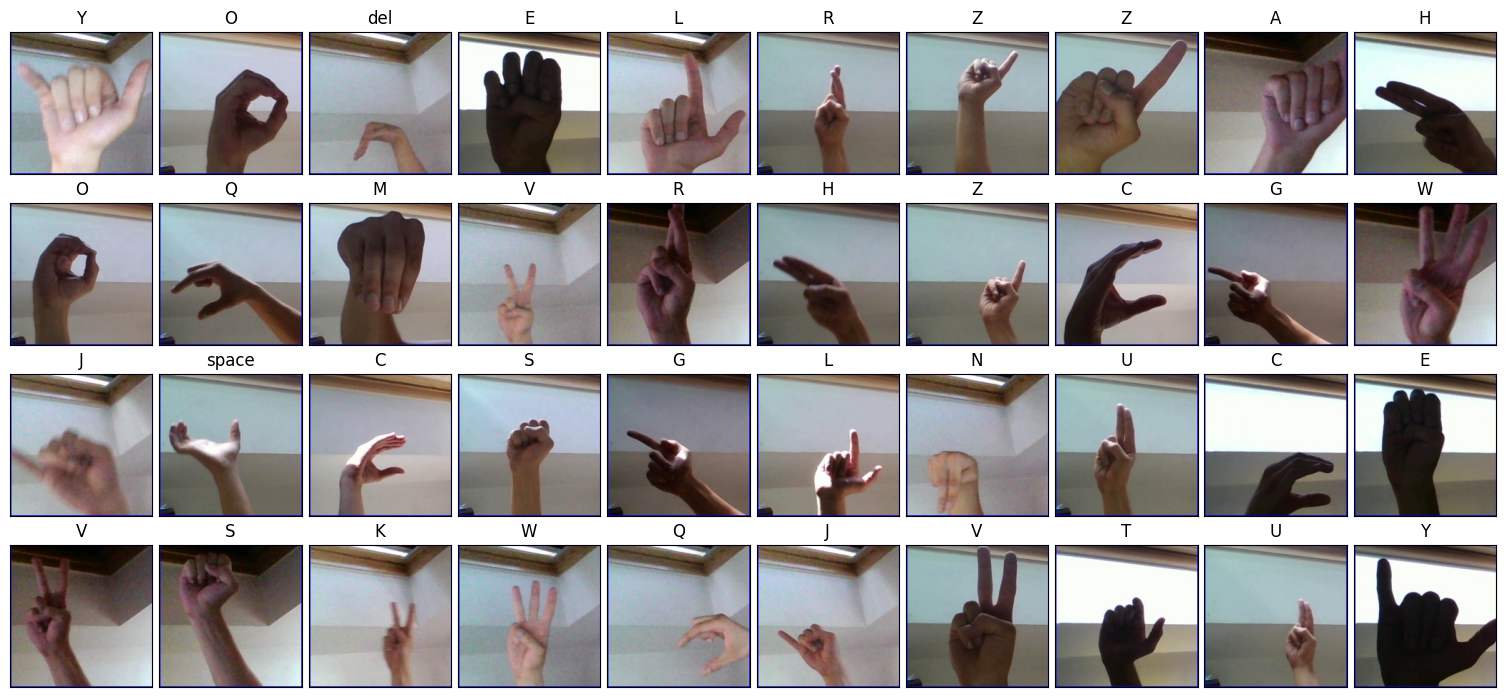

In [6]:
# Display 40 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_df.Filepath[i]))
    ax.set_title(train_df.Label[i])
    
plt.tight_layout(pad=.5)
plt.show()

In [7]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2, rotation_range = 30 , fill_mode = 'nearest' , zoom_range = 0.2 ,
    shear_range = 0.2 , width_shift_range=0.1, height_shift_range=0.1,
    brightness_range = [0.2,1.0]
)
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [8]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training',
)
val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 69600 validated image filenames belonging to 29 classes.
Found 17400 validated image filenames belonging to 29 classes.
Found 28 validated image filenames belonging to 1 classes.


In [9]:
pretrainedModel = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrainedModel.trainable = False

In [10]:
print(tf.__version__)

for device in tf.config.list_physical_devices():
    print(device)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.19.0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
Num GPUs Available:  0


In [11]:
inputs = pretrainedModel.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrainedModel.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(29, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
#adam = tf.keras.optimizers.Adam(
# learning_rate=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
# name='Adam'
#)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=3,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)



C:\Users\Kamil\PycharmProjects\sign-language-recognition\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 1689s 774ms/step - accuracy: 0.6957 - loss: 1.0398 - val_accuracy: 0.9011 - val_loss: 0.2987
Epoch 2/3
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 1166s 536ms/step - accuracy: 0.8910 - loss: 0.3329 - val_accuracy: 0.8997 - val_loss: 0.3078
Epoch 3/3
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 1158s 532ms/step - accuracy: 0.9116 - loss: 0.2696 - val_accuracy: 0.9249 - val_loss: 0.2295


In [14]:
model.save("model.keras")
model.save("model.h5")


In [16]:
model = tf.keras.models.load_model("models/model.keras")
model.export("models/saved_model")

C:\Users\Kamil\PycharmProjects\sign-language-recognition\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


INFO:tensorflow:Assets written to: models/saved_model\assets


INFO:tensorflow:Assets written to: models/saved_model\assets


Saved artifact at 'models/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 29), dtype=tf.float32, name=None)
Captures:
  2437349162832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2437349162064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2437456922768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2437345632784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2437345631824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2437456921424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2437345630288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2437345625104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2437345629136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2437345628560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2437345629904: TensorSpec(shape=

In [22]:
# Evaluate

#print(model.summary())

#print(test_df)

# results = model.evaluate(test_images, verbose=0)
# print(" Test Loss: {:.5f}".format(results[0]))
# print("Test Accuracy: {:.2f}%".format(results[1] * 100))

In [24]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

ValueError: Layer "functional" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor 'data:0' shape=(28, 224, 224, 3) dtype=float32>, <tf.Tensor 'data_1:0' shape=(28, 1) dtype=float32>]

In [37]:
# categorizing one image
img_batch, label_batch = next(test_images)

# Select the first image in the batch
one_image = img_batch[5]
one_label = label_batch[5]  # optional, if you want to compare the true label

# Model expects input shape (1, height, width, channels)
one_image_expanded = np.expand_dims(one_image, axis=0)

# Predict
pred = model.predict(one_image_expanded)
pred_class = np.argmax(pred, axis=1)[0]

print(pred_class)

# Map predicted index to class name
labels = (train_images.class_indices)
labels = dict((v, k) for k, v in labels.items())

predicted_label = labels[pred_class]

# Display result
print(f"Predicted label: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
0
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}
{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'del', 27: 'nothing', 28: 'space'}
Predicted label: A


In [38]:
import json

labels = (train_images.class_indices)

# saving labels to file for future use in app
with open("labels.json", "w") as f:
    json.dump(labels, f)